Methods to reduce over-fitting of a Network
- Add more data: No more data avilable
- Reduce the complexity of the model: Our architecture is already simple
- Regularization: L2 regularization - regularization parameter lambda
- Batch Normalization: normalize the batch input for each hidden layer - applied before the activation function
- Dropouts: Randomly turn off certain p% neurons during training - reduces overfitting - as the model becomes simpler, reduces overfitting - appliead after activation
- Data Augmentation: Transforming data like rotating it and making copies of it - so it can generalize well(works well in CNN)
- Early stopping: stopping training if loss doesn't decrease considerably

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time

In [2]:
train_data_path = r"E:\AbioticNeuron\DS\Pytorch\fmnist_problem\dataset\fashion-mnist_train.csv"
test_data_path = r"E:\AbioticNeuron\DS\Pytorch\fmnist_problem\dataset\fashion-mnist_test.csv"
x_dtype = torch.float32
y_dtype = torch.long
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# torch.device('cpu') 
print(device)
learning_rate = 0.1
epochs = 100

cuda


## Data Preparation

In [3]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [4]:
train_data_x = train_data.iloc[:, 1:]/255.0
train_data_y = train_data.iloc[:,0]

test_data_x = test_data.iloc[:, 1:]/255.0
test_data_y = test_data.iloc[:,0]

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, input_x, input_y, device):
        super().__init__()
        # Convert to tensors and move to device once
        self.x = torch.tensor(input_x.values, dtype=x_dtype, device=device)
        self.y = torch.tensor(input_y.values, dtype=y_dtype, device=device)

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [6]:
train_dataset = FMNISTDataset(train_data_x, train_data_y, device)
test_dataset = FMNISTDataset(test_data_x, test_data_y, device)

train_data_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

## Modified Model Architecture

In [7]:
class NNModel(torch.nn.Module):
    def __init__(self, num_features, l_r):
        super().__init__()
        self.neural_network = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),   # have added batch normalization layers
            nn.ReLU(),
            nn.Dropout(p=0.3),    # have added dropouts 30%
            nn.Linear(64, 10)
        )
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(params=self.neural_network.parameters(), lr=l_r, weight_decay=1e-4) # have added 1e-4 lambda for regularization
        self.loss = None

    def forward(self, x):
        return self.neural_network(x)

    # change method
    def backward(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



## Model Training

In [8]:
model = NNModel(num_features=784, l_r=learning_rate)
model = model.to(device=device) # moving to gpu

In [9]:
epoch_losses = []

start_time = time.time()
for epoch in range(epochs):
    epoch_loss = 0.0
    batch_count = 0
    
    for batch_idx, (features, label) in enumerate(train_data_loader):
        
        prediction = model(features)
        loss = model.loss_function(prediction, label)
        model.backward(loss=loss)
 
        epoch_loss += loss.item()
        batch_count += 1

    avg_loss = epoch_loss / batch_count
    epoch_losses.append(avg_loss)
    print(f"Epoch-{epoch} Average Loss: {avg_loss:.4f}")

stop_time = time.time()
print(f"Total Training Time: {stop_time - start_time:.2f} seconds")


Epoch-0 Average Loss: 0.6033
Epoch-1 Average Loss: 0.4632
Epoch-2 Average Loss: 0.4271
Epoch-3 Average Loss: 0.4046
Epoch-4 Average Loss: 0.3927
Epoch-5 Average Loss: 0.3747
Epoch-6 Average Loss: 0.3671
Epoch-7 Average Loss: 0.3554
Epoch-8 Average Loss: 0.3480
Epoch-9 Average Loss: 0.3402
Epoch-10 Average Loss: 0.3324
Epoch-11 Average Loss: 0.3278
Epoch-12 Average Loss: 0.3234
Epoch-13 Average Loss: 0.3195
Epoch-14 Average Loss: 0.3151
Epoch-15 Average Loss: 0.3097
Epoch-16 Average Loss: 0.3101
Epoch-17 Average Loss: 0.3057
Epoch-18 Average Loss: 0.3006
Epoch-19 Average Loss: 0.2975
Epoch-20 Average Loss: 0.2949
Epoch-21 Average Loss: 0.2939
Epoch-22 Average Loss: 0.2893
Epoch-23 Average Loss: 0.2880
Epoch-24 Average Loss: 0.2863
Epoch-25 Average Loss: 0.2831
Epoch-26 Average Loss: 0.2799
Epoch-27 Average Loss: 0.2796
Epoch-28 Average Loss: 0.2781
Epoch-29 Average Loss: 0.2757
Epoch-30 Average Loss: 0.2772
Epoch-31 Average Loss: 0.2724
Epoch-32 Average Loss: 0.2698
Epoch-33 Average Los

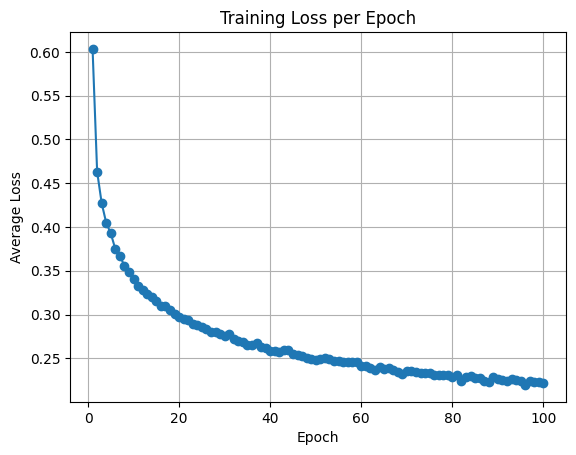

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()

## Model Evaluation

In [11]:
model.eval()

train_total = 0
train_correct = 0
test_total = 0
test_correct = 0

with torch.no_grad():
    # Train data accuracy
    for x, y in train_data_loader:
        y_pred = model(x)                          # (batch_size, num_classes)
        predicted = torch.argmax(y_pred, dim=1)    # (batch_size,)
        train_total += y.size(0)
        train_correct += (predicted == y).sum().item()

    # Test data accuracy
    for x, y in test_data_loader:
        y_pred = model(x)
        predicted = torch.argmax(y_pred, dim=1)
        test_total += y.size(0)
        test_correct += (predicted == y).sum().item()

# Results (formatted)
print("=" * 50)
print(f"{'Dataset':<12} {'Size':>8} {'Accuracy':>12}")
print("-" * 50)
print(f"{'Train':<12} {train_total:>8} {train_correct / train_total:>11.4%}")
print(f"{'Test':<12} {test_total:>8} {test_correct / test_total:>11.4%}")
print("=" * 50)


Dataset          Size     Accuracy
--------------------------------------------------
Train           60000    94.5283%
Test            10000    89.5800%


## Saving the Weights

In [12]:
# Save
torch.save(model.state_dict(), "ann2.pth")